# Get damping derivatives by adding additional velocities into v_inf

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from lltdrek import Wing, FlightCondition, WingPool, Simulation, PostProcessing, load_folder

airfoils_data, _ = load_folder("../sample_airfoils")
alpha_list = [alpha for alpha in range(5)]

def get_coefs(q):
    wing = Wing(
        spans=[1],
        chords=[0.3, 0.3],
        offsets=[0, 0],
        twist_angles=[0, 0],
        dihedral_angles=[0, 0],
        airfoils=["NACA4412", "NACA4412", "NACA4412"],
        surface_name="wing",
        N_panels=12,
        distribution_type="cosine",
        sweep_check=False,
    )
    wing.generate_mesh()  # Generate wing simulation elements

    flight_condition = FlightCondition(
        V_inf=20,
        nu=1.5e-5,
        rho=1.225,
        angles_of_attack=alpha_list,
        h=0,
        ground_effect_check=False,
        angular_velocity=[0, q, 0]
    )
    wing.setup_airfoil_data(flight_condition, airfoils_data)  # Assign airfoil data to wing

    # Link wing that will be simulated with flight condition
    wing_pool = WingPool(wing_list=[wing], flight_condition=flight_condition, moment_ref=[0, 0, 0])

    simulation = Simulation(
        damping_factor = 0.4,
        max_iter = 100,
        max_residual = 1e-4,
        linear_check = True,
        show_logs = True,
        simulation_mode = "linear_first" # Solves linear version of equations before doing non linear simulation to speed up process
    )
    simulation_results = simulation.run(wing_pool)
    post_processing = PostProcessing()
    coefficients = post_processing.get_coefficients(wing_pool, simulation_results)
    CL_list = []
    CM_list = []
    CD_list = []

    for coef in coefficients:
        CL_list.append(coef.global_coefficients.forces[2])
        CM_list.append(coef.global_coefficients.moments[1])
        CD_list.append(coef.global_coefficients.forces[0])
    return CL_list, CM_list, CD_list


In [2]:
"""
Unsteady flow
-------------
AVL assumes quasi-steady flow, meaning that unsteady vorticity shedding
is neglected.  More precisely, it assumes the limit of small reduced frequency,
which means that any oscillatory motion (e.g. in pitch) must be slow enough
so that the period of oscillation is much longer than the time it takes
the flow to traverse an airfoil chord.  This is true for virtually any
expected flight maneuver.  Also, the roll, pitch, and yaw rates used
in the computations must be slow enough so that the resulting relative
flow angles are small.  This can be judged by the dimensionless
rotation rate parameters, which should fall within the following
practical limits.

-0.10 < pb/2V < 0.10
-0.03 < qc/2V < 0.03
-0.25 < rb/2V < 0.25
"""
c = 0.3
V = 20
q_max = 0.03 * 2 * V / c
print(q_max) # 4.0
q_values = [0, 0.05, 0.1, 0.5, 1, 2, 4]

results_CL = []
results_CM = []
results_CD = []
for q in q_values:
    CL_list, CM_list, CD_list = get_coefs(q)
    results_CL.append(CL_list)
    results_CM.append(CM_list)
    results_CD.append(CD_list)


4.0
Running simulation for angles between 0 and 4
Linear simulation check: False
Found solution for angle 0
number of iterations: 14
Found solution for angle 1
number of iterations: 14
Found solution for angle 2
number of iterations: 14
Found solution for angle 3
number of iterations: 14
Found solution for angle 4
number of iterations: 14
Running simulation for angles between 0 and 4
Linear simulation check: False
Found solution for angle 0
number of iterations: 14
Found solution for angle 1
number of iterations: 14
Found solution for angle 2
number of iterations: 14
Found solution for angle 3
number of iterations: 14
Found solution for angle 4
number of iterations: 14
Running simulation for angles between 0 and 4
Linear simulation check: False
Found solution for angle 0
number of iterations: 14
Found solution for angle 1
number of iterations: 14
Found solution for angle 2
number of iterations: 14
Found solution for angle 3
number of iterations: 14
Found solution for angle 4
number of 

In [3]:
import numpy as np

idx = 4

CLq = (results_CL[idx][2]-results_CL[0][2]) / (q_values[idx] - q_values[0])
# AVL value: 13.286085
print(f"CLq: {CLq * 180 / np.pi}")

# AVL value: -4.708526
CMq = (results_CM[idx][2]-results_CM[0][2]) / (q_values[idx] - q_values[0])
print(f"CMq: {CMq * 180 / np.pi}")

CLq: 19.774876532910092
CMq: -4.921191929740203


In [4]:
print(len(results_CM))
print(len(results_CM[0]))

7
5


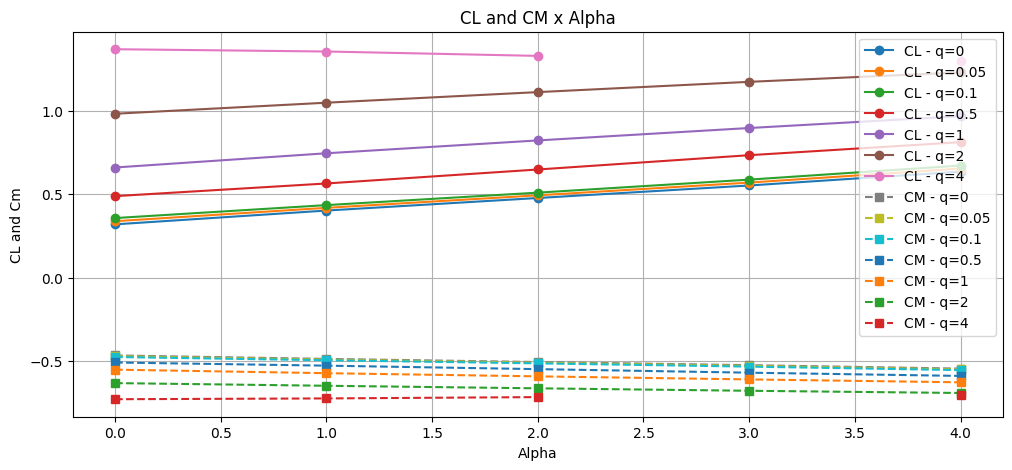

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 5))
for i in range(7):
    plt.plot(alpha_list, results_CL[i], marker='o', linestyle='-', label=f'CL - q={q_values[i]}')

for i in range(7):
    plt.plot(alpha_list, results_CM[i], marker='s', linestyle='--', label=f'CM - q={q_values[i]}')

# Labels and legend
plt.xlabel("Alpha")
plt.ylabel("CL and Cm")
plt.title("CL and CM x Alpha")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
